## Setup

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.8)

Usando dispositivo: cuda


In [2]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [3]:
def plot_token_count(row1, row2, log=False):
    # compute token counts (including [CLS] and [SEP])
    token_counts_es = row1.apply(
        lambda txt: len(tokenizer.encode(txt))
    )

    token_counts_lf = row2.apply(
        lambda txt: len(tokenizer.encode(txt))
    )

    plt.figure(figsize=(10, 5))
    plt.hist(token_counts_es, bins=50, alpha=0.5, label='Espaniol', color='r')
    plt.hist(token_counts_lf, bins=50, alpha=0.5, label='Lunfardo', color='b', log=log)
    plt.axvline(512, color='r', linestyle='--', label='BERT max length')
    plt.xlabel("tokens")
    plt.ylabel("Cantidad de secuencias")
    plt.legend()
    plt.show()

## 1000 dataset

In [4]:
# cargamos los datos small
data = pd.read_csv('../../data/es_MX-es_LF_small.txt', sep='\t', header=None)
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,representaciones de la tierra y el agua de sis...,¡las labras de la tierra y el agua mierda son ...
1,gente nadando en la alberca 2022 es una de las...,gente chapoteando en la pileta 2022 es uno de ...
2,tierra del sol se complace en presentar vicent...,tierra del sol se pone el moño pa' presentarte...
3,"trabajando con maestría diversas temáticas, si...","con un chamuyo bárbaro, el siso se mandó una b..."
4,la galería tierra del sol se encuentra en el 7...,la canchita tierra del sol la garrás en el 741...


In [5]:
# testeamos el tokenizador de BERT
input_0 = data['spanish'][0]
target_0 = data['lunfardo'][0]

print(f"Input: {input_0}")
print(f"Target: {target_0}")

print(tokenizer.tokenize(input_0))
print(tokenizer.tokenize(target_0))

print(tokenizer.encode(input_0))
print(tokenizer.encode(target_0))

Input: representaciones de la tierra y el agua de siso son el centro de una nueva exposición
Target: ¡las labras de la tierra y el agua mierda son el eje de un quilombo nuevo!
['representacion', '##es', 'de', 'la', 'tierra', 'y', 'el', 'agua', 'de', 'sis', '##o', 'son', 'el', 'centro', 'de', 'una', 'nueva', 'exposicion']
['¡', 'las', 'lab', '##ras', 'de', 'la', 'tierra', 'y', 'el', 'agua', 'mie', '##rda', 'son', 'el', 'eje', 'de', 'un', 'qui', '##lom', '##bo', 'nuevo', '!']
[101, 37889, 10165, 10102, 10106, 15456, 167, 10117, 13479, 10102, 21445, 10132, 10289, 10117, 11995, 10102, 10155, 12782, 38663, 102]
[101, 173, 10265, 31494, 13026, 10102, 10106, 15456, 167, 10117, 13479, 95096, 22741, 10289, 10117, 61529, 10102, 10119, 10379, 21440, 11976, 13976, 106, 102]


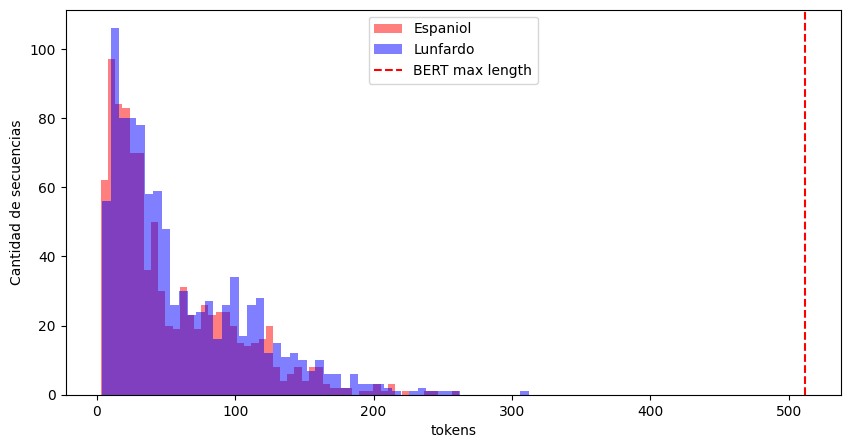

In [6]:
import matplotlib.pyplot as plt

plot_token_count(data['spanish'], data['lunfardo'])

Truncamos a 256 tokens para poder procesar las 2 secuencias al mismo tiempo

In [7]:
BERT = BertModel.from_pretrained("bert-base-multilingual-uncased").eval()
batch0 = torch.tensor(tokenizer.encode(input_0)).unsqueeze(0)

with torch.inference_mode():
    bert_output = BERT(batch0)

print(input_0)
print(tokenizer.encode(input_0))
print(len(tokenizer.encode(input_0)))
print(batch0.shape)
print(bert_output.last_hidden_state.shape) # ultima capa oculta
print(bert_output.pooler_output.shape) # salida de la capa de pooling

representaciones de la tierra y el agua de siso son el centro de una nueva exposición
[101, 37889, 10165, 10102, 10106, 15456, 167, 10117, 13479, 10102, 21445, 10132, 10289, 10117, 11995, 10102, 10155, 12782, 38663, 102]
20
torch.Size([1, 20])
torch.Size([1, 20, 768])
torch.Size([1, 768])


In [8]:
tokenizer.decode(tokenizer.encode(input_0))

'[CLS] representaciones de la tierra y el agua de siso son el centro de una nueva exposicion [SEP]'

In [9]:
bert_output.pooler_output.shape

torch.Size([1, 768])

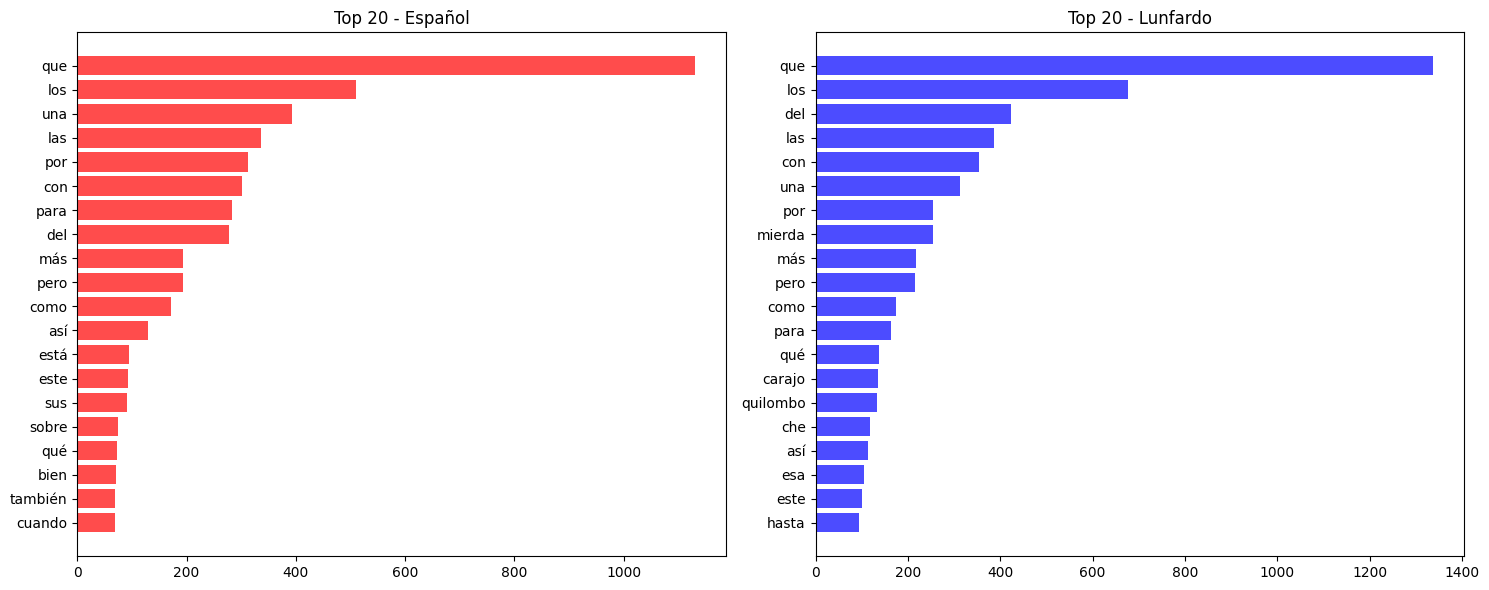

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
import re

def get_top_words(texts, n=20):
    all_text = " ".join(texts)
    words = re.findall(r'\b[a-záéíóúñ]+\b', all_text.lower())
    words = [w for w in words if len(w) > 2]
    return Counter(words).most_common(n)

spanish_top = get_top_words(data['spanish'])
lunfardo_top = get_top_words(data['lunfardo'])

# grafico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

words_es = [w for w, c in spanish_top]
counts_es = [c for w, c in spanish_top]
ax1.barh(words_es, counts_es, color='red', alpha=0.7)
ax1.set_title('Top 20 - Español')
ax1.invert_yaxis()

words_lf = [w for w, c in lunfardo_top]
counts_lf = [c for w, c in lunfardo_top]
ax2.barh(words_lf, counts_lf, color='blue', alpha=0.7)
ax2.set_title('Top 20 - Lunfardo')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [11]:
tokenizer.sep_token_id

102

In [12]:
BERT = BertModel.from_pretrained("bert-base-multilingual-uncased").to(device).eval()
for param in BERT.parameters():
    param.requires_grad = False
embeddings = BERT.embeddings.word_embeddings.weight
del BERT
torch.cuda.empty_cache()
embeddings = embeddings.detach()

In [13]:
embeddings.shape

torch.Size([105879, 768])

In [14]:
torch.cuda.empty_cache()

In [15]:
embeddings = BertModel.from_pretrained("bert-base-multilingual-uncased").to(device).eval().embeddings.word_embeddings.weight.detach()
torch.cuda.empty_cache()
embeddings

tensor([[ 0.0572,  0.0410,  0.0418,  ..., -0.0093,  0.0087, -0.0015],
        [ 0.0530,  0.0282,  0.0274,  ..., -0.0146,  0.0084,  0.0024],
        [ 0.0617,  0.0041,  0.0368,  ...,  0.0005, -0.0120, -0.0046],
        ...,
        [ 0.0324,  0.0460,  0.0023,  ..., -0.0438, -0.0149,  0.0450],
        [ 0.0455,  0.0294,  0.0241,  ..., -0.0237, -0.0207,  0.0211],
        [ 0.0272,  0.0486,  0.0077,  ...,  0.0108, -0.0339,  0.0175]],
       device='cuda:0')

## 2M dataset

In [16]:
# cargamos los datos small
data = pd.read_csv('../../data/es-gl.txt', sep='\t', header=None, on_bad_lines='skip')
data.columns = ['spanish', 'gl']

# Count NaN values in each column
nan_counts = data.isna().sum()

# Get text length stats for each column
length_stats = {}
for col in ['spanish', 'gl']:
    lengths = data[col].dropna().apply(len)
    length_stats[col] = {
        'min_len': round(lengths.min()),
        'max_len': round(lengths.max()),
        'avg_len': round(lengths.mean()),
        'median_len': round(lengths.median())
    }

print("Lenght:", len(data))
print("NaN counts:\n", nan_counts)
print("\nLength stats (characters):")
for col, stats in length_stats.items():
    print(f"{col}: {stats}")

data.head()

Lenght: 1863187
NaN counts:
 spanish       0
gl         1627
dtype: int64

Length stats (characters):
spanish: {'min_len': 8, 'max_len': 39462, 'avg_len': 146, 'median_len': 124}
gl: {'min_len': 7, 'max_len': 42524, 'avg_len': 140, 'median_len': 118}


,spanish,gl
0,Esta vez el cuadro local con el segundo de la ...,Gañou confianza o cadro local co segundo da ta...
1,Notas especiales: Esta unidad puede moverse si...,Notas especiais: esta unidade pode moverse na ...
2,"En este último caso, normalmente es un rey, pe...","Neste último caso, normalmente é un rei, pero ..."
3,Además de nuestras oficinas provinciales y del...,Ademais das nosas oficinas provinciais e deleg...
4,Si tienes cualquier duda o sugerencia que hace...,Se tes calquera dúbida ou suxestión que nos fa...


In [17]:
data = data[-data['gl'].isna()]

Token indices sequence length is longer than the specified maximum sequence length for this model (2883 > 512). Running this sequence through the model will result in indexing errors


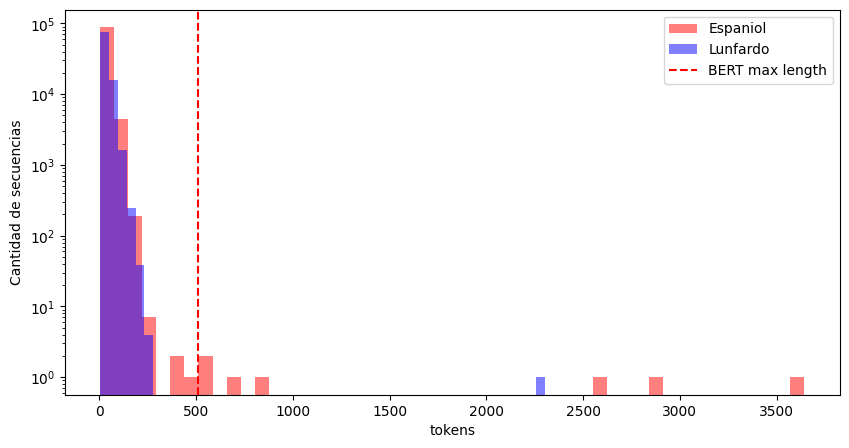

In [18]:
from sklearn.model_selection import train_test_split

_, data_sample = train_test_split(data, test_size=0.05, random_state=28)

plot_token_count(data_sample['spanish'], data_sample['gl'], log=True)

No es Lunfardo, es gl ~ gallego?

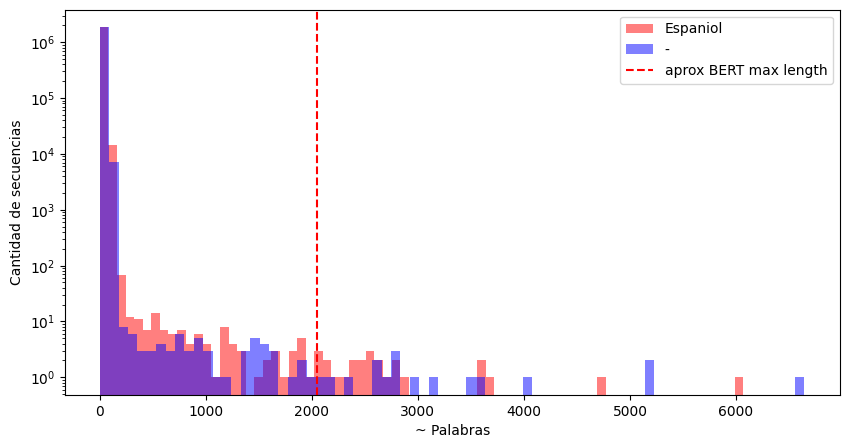

In [43]:
def plot_word_count(row1, row2, log=False):
    # compute token counts (including [CLS] and [SEP])
    token_counts_es = row1.apply(
        lambda txt: len(txt.split(' '))
    )

    token_counts_lf = row2.apply(
        lambda txt: len(txt.split(' '))
    )

    plt.figure(figsize=(10, 5))
    plt.hist(token_counts_es, bins=75, alpha=0.5, label='Espaniol', color='r')
    plt.hist(token_counts_lf, bins=75, alpha=0.5, label='-', color='b', log=log)
    plt.axvline(512*4, color='r', linestyle='--', label='aprox BERT max length')
    plt.xlabel("~ Palabras")
    plt.ylabel("Cantidad de secuencias")
    plt.legend()
    plt.show()

plot_word_count(data['spanish'], data['gl'], log=True)

In [46]:
# cota para filtrar
sum(data['spanish'].apply(lambda txt: len(txt.split(' '))) >= 512/8)

45474

In [56]:
data_filtered = data[data['spanish'].apply(lambda txt: len(txt.split(' '))) <= 512/8]
data_filtered

,spanish,gl
0,Esta vez el cuadro local con el segundo de la ...,Gañou confianza o cadro local co segundo da ta...
1,Notas especiales: Esta unidad puede moverse si...,Notas especiais: esta unidade pode moverse na ...
2,"En este último caso, normalmente es un rey, pe...","Neste último caso, normalmente é un rei, pero ..."
3,Además de nuestras oficinas provinciales y del...,Ademais das nosas oficinas provinciais e deleg...
4,Si tienes cualquier duda o sugerencia que hace...,Se tes calquera dúbida ou suxestión que nos fa...
...,...,...
1863182,"Se denominan anfidios, fasmidios o deiridios s...","Denomínanse anfidios, fasmidios ou deiridios s..."
1863183,"Lo importante, en el fondo, no es pertenecer a...","O importante, no fondo, non é pertencer a un g..."
1863184,El personaje de Lola vuelve a aparecer en la e...,A personaxe de Lola volveu aparecer na experim...
1863185,"También aparece el Golem, no obstante, no tien...","Tamén aparece o Golem, porén, non ten que ver ..."


In [60]:
len_words = data['spanish'].apply(lambda txt: len(txt.split(' ')))
data_filtered = data[(len_words >= 2) & (len_words <= 512/8)]
data_filtered

,spanish,gl
0,Esta vez el cuadro local con el segundo de la ...,Gañou confianza o cadro local co segundo da ta...
1,Notas especiales: Esta unidad puede moverse si...,Notas especiais: esta unidade pode moverse na ...
2,"En este último caso, normalmente es un rey, pe...","Neste último caso, normalmente é un rei, pero ..."
3,Además de nuestras oficinas provinciales y del...,Ademais das nosas oficinas provinciais e deleg...
4,Si tienes cualquier duda o sugerencia que hace...,Se tes calquera dúbida ou suxestión que nos fa...
...,...,...
1863182,"Se denominan anfidios, fasmidios o deiridios s...","Denomínanse anfidios, fasmidios ou deiridios s..."
1863183,"Lo importante, en el fondo, no es pertenecer a...","O importante, no fondo, non é pertencer a un g..."
1863184,El personaje de Lola vuelve a aparecer en la e...,A personaxe de Lola volveu aparecer na experim...
1863185,"También aparece el Golem, no obstante, no tien...","Tamén aparece o Golem, porén, non ten que ver ..."


In [50]:
from sklearn.model_selection import train_test_split

_, data_sampled = train_test_split(data_filtered, test_size=100000, random_state=28)
data_sampled

,spanish,gl
1271222,Si bien la biografía de Harrison cuenta alguna...,Aínda que a biografía de Harrison conta algunh...
1827622,"Quiero ser un buen compañero, preocuparme por ...","Quero ser un bo compañeiro, preocuparme polos ..."
1707207,A todos mis amigos que tengo fuera del Club.,A todos os meus amigos que teño fóra do Club.
89640,Material escolar y de escritorio para estudian...,Material escolar e de escritorio para estudant...
177574,"García ha destacado ""la variedad de perspectiv...","García destacou ""a variedade de perspectivas e..."
...,...,...
388779,Supone un coste económico y medioambiental que...,Supón un custo económico e ambiental que hai q...
434880,"Al medir las longitudes de onda, y compararlas...","Ao medir as lonxitudes de onda, e comparalas c..."
521261,Era frecuente el consumo de carne de aves y ce...,Era frecuente o consumo de carne de aves e por...
1519108,>> VITAMINAS Y MINERALES EN ALIMENTOS Qué lech...,>> ALIMENTOS RICOS EN FóSFORO Cal fermentado e...


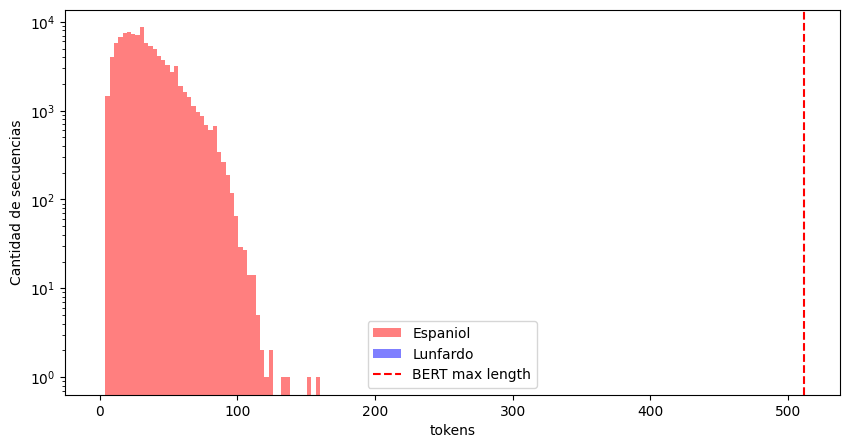

In [53]:
plot_token_count(data_sampled['spanish'], pd.Series([]), log=True)

In [55]:
data_sampled['spanish'].to_list()

['Si bien la biografía de Harrison cuenta algunas anécdotas de su etapa con los Beatles, se centra en su mayoría en los hobbies del artista, desde la jardinería hasta la Fórmula Uno.',
 'Quiero ser un buen compañero, preocuparme por los demás,',
 'A todos mis amigos que tengo fuera del Club.',
 'Material escolar y de escritorio para estudiantes, profesionales y empresas en Felanitx',
 'García ha destacado "la variedad de perspectivas y de ámbitos de acción" de las experiencias de trabajo, "una muestra significativa de la enorme dosis de iniciativa y de creatividad que atesora el profesorado que promueve el gallego dentro y fuera de las aulas".',
 'Todo nuestro amado Profeta (salla Allahu Alihi wa salam) dijo e hizo fue un acto de adoración, y los siguientes son solo algunos de los numerosos ejemplos.',
 'Broche en plata de primera ley (925 milésimas).',
 'Armas cortas, munición en el cargador, personal poseedor de licencia tipo B.',
 'Capital de largo plazo: es el tipo de capital del c